In [1]:
## Importing libraries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# from chart_studio.plotly import plotly
# import plotly.offline as offline
# import plotly.graph_objs as go
#offline.init_notebook_mode()
from collections import Counter

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !pip install tensorflow==1.15.0
# !pip install keras==2.3.1
# # import tensorflow
# tensorflow.__version__

In [5]:
# !cp -r '/content/drive/My Drive/LSTM_preprocessed/model1/processed_data_split.h2' '/content/'
# !cp -r '/content/drive/My Drive/LSTM_preprocessed/model1/model_inputs.pkl' '/content/'
# !cp -r '/content/drive/My Drive/LSTM_preprocessed/model1/model_input_cat_lables.pkl' '/content/'
# !cp -r  '/content/drive/My Drive/_datasets/glove_vectors' '/content/'

In [6]:
## Load data after split
x_train = pd.read_hdf('processed_data_split.h2', 'x_train',mode='r')
x_test = pd.read_hdf('processed_data_split.h2', 'x_test',mode='r') 
x_cv = pd.read_hdf('processed_data_split.h2', 'x_cv',mode='r')
y_train =pd.read_hdf('processed_data_split.h2', 'y_train',mode='r')
y_test =pd.read_hdf('processed_data_split.h2', 'y_test',mode='r')
y_cv =pd.read_hdf('processed_data_split.h2', 'y_cv',mode='r')
print('*'*50)
print(' Successfully loaded processed split data')
emd_i,embedding_matrix,seq_x_train,seq_x_test,seq_x_cv,padseq_x_train,sklstate_train,proj_grade_train,train_categories,train_subcategories,teacher_prefix_train,numerical_train,padseq_x_test,sklstate_test,proj_grade_test,test_categories,test_subcategories,teacher_prefix_test,numerical_test,padseq_x_cv,sklstate_cv,proj_grade_cv,cv_categories,cv_subcategories,teacher_prefix_cv,numerical_cv = pickle.load(open('model_inputs.pkl','rb'))
print('*'*50)
print(' Successfully loaded model input variables')
y_train_cat,y_test_cat,y_cv_cat = pickle.load(open('model_input_cat_lables.pkl', 'rb'))
print('*'*50)
print('Successfully loaded split y labels')

**************************************************
 Successfully loaded processed split data
**************************************************
 Successfully loaded model input variables
**************************************************
Successfully loaded split y labels


In [12]:
vocab_size = embedding_matrix.shape[0]

### Model-3

<img src='https://i.imgur.com/fkQ8nGo.png'>
ref: https://i.imgur.com/fkQ8nGo.png


- __input_seq_total_text_data__: <br>
<pre>
    . Use text column('essay'), and use the Embedding layer to get word vectors. <br>
    . Use given predefined glove word vectors, don't train any word vectors. <br>
    . Use LSTM that is given above, get the LSTM output and Flatten that output. <br>
    . You are free to preprocess the input text as you needed. <br>
</pre>
- __Other_than_text_data__:<br>
<pre>
    . Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors <br>
    . Neumerical values and use <a href='https://keras.io/getting-started/sequential-model-guide/#sequence-classification-with-1d-convolutions'>CNN1D</a> as shown in above figure. <br>
    . You are free to choose all CNN parameters like kernel sizes, stride.<br>
    
</pre>

### 3.1 Hyperparameter Tuning


In [8]:
from scipy.sparse import hstack
other_than_text_train = hstack((sklstate_train,proj_grade_train,train_categories,train_subcategories,teacher_prefix_train,numerical_train)).todense()
other_than_text_test = hstack((sklstate_test,proj_grade_test,test_categories,test_subcategories,teacher_prefix_test,numerical_test)).todense()
other_than_text_cv = hstack((sklstate_cv,proj_grade_cv,cv_categories,cv_subcategories,teacher_prefix_cv,numerical_cv)).todense()

In [9]:
other_than_text_train = np.expand_dims(other_than_text_train,2)
other_than_text_test = np.expand_dims(other_than_text_test,2)
other_than_text_cv = np.expand_dims(other_than_text_cv,2)

In [10]:
print(other_than_text_train.shape)
print(other_than_text_test.shape)
print(other_than_text_cv.shape)

(69918, 102, 1)
(21850, 102, 1)
(17480, 102, 1)


In [11]:
import tensorflow as tf
from keras.callbacks import TensorBoard,ModelCheckpoint
import keras
import datetime, os
import keras.backend as K
from keras.regularizers import l2
from tensorflow import set_random_seed
from sklearn.metrics import roc_auc_score
from keras.layers import Dropout,Input,Activation,Dense,Embedding,concatenate,LSTM,Flatten,BatchNormalization
from keras.layers import Conv1D,MaxPool1D
from keras.models import Model
# Load the TensorBoard notebook extension
%load_ext tensorboard

def aucroc(y_true,y_pred):
    try:
        return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)
    except ValueError:
        pass

Using TensorFlow backend.


In [9]:
## clear the graph of the tensorflow
K.clear_session()
### defining all the Input layer 
input_seq_total_text_data = Input(shape=padseq_x_train[0].shape,name='text_Input')
input_other_than_text = Input(shape=(102,1),name='other_than_text')

set_random_seed(5)
auc_scores_model3=[]
if not os.path.isfile('tuning_output_model3.pkl'):
    for k_s in [3,5,10]:
      for stride in [1,2,3]:
        for mx_p in [3,5]:
            #definig embedding layer
            embed_text_data = Embedding(vocab_size,300,weights = [embedding_matrix],trainable=False)(input_seq_total_text_data)
            #embed_other_than_text = Embedding(other_than_text_train.shape[1],other_than_text_train.shape[1]//e)(input_other_than_text)
            ##defining LSTM layer 
            lstm_layer = LSTM(128,return_sequences=True)(embed_text_data)
            ##convolutional layer
            for c_i in [64,128,256]:
                conv_1 = Conv1D(c_i,kernel_size=k_s,strides=stride,padding='same',activation='relu',kernel_initializer='he_normal')(input_other_than_text)
                conv_2 = Conv1D(c_i,kernel_size=k_s,strides=stride,padding='same',activation='relu',kernel_initializer='he_normal')(conv_1)
                max_pool = MaxPool1D(pool_size=(3),padding='same')(conv_2)
                conv_3 = Conv1D(c_i,kernel_size=k_s,strides=stride,padding='same',activation='relu',kernel_initializer='he_normal')(max_pool)
                conv_4 = Conv1D(c_i,kernel_size=k_s,strides=stride,padding='same',activation='relu',kernel_initializer='he_normal')(conv_3)
                max_pool = MaxPool1D(pool_size=(3),padding='same')(conv_4)
            #max_pool = MaxPool1D(pool_size=(mx_p),padding='same')(conv_2)
            #flatten layer
            flatten_1 = Flatten()(lstm_layer) 
            flatten_2 = Flatten()(max_pool)
            # concat layer
            concat_layer =  concatenate([flatten_1,flatten_2])
            #dense layers
            dense_layer_1 =  Dense(512,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.0001))(concat_layer)
            regularization = BatchNormalization()(dense_layer_1)
            regularization = Dropout(0.25)(regularization)
            dense_layer_2 =  Dense(256,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.0001))(regularization)
            regularization = BatchNormalization()(dense_layer_2)
            dense_layer_3 =  Dense(128,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.0001))(regularization)
            regularization = BatchNormalization()(dense_layer_3)
            regularization = Dropout(0.25)(dense_layer_3)
            out_layer = Dense(2,activation='softmax',kernel_initializer='glorot_normal',kernel_regularizer=l2(0.0001))(dense_layer_3)

            model3 = Model(inputs=[input_seq_total_text_data,input_other_than_text],outputs=[out_layer])

            # https://stackoverflow.com/questions/48285129/saving-best-model-in-keras
            # Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used.
            model3.compile(optimizer=keras.optimizers.Adam(),loss='categorical_crossentropy',metrics=['accuracy',aucroc])

            callback = tf.keras.callbacks.EarlyStopping(monitor='val_aucroc',verbose=1, patience=2,restore_best_weights=True,mode='max')

            history = model3.fit([padseq_x_train,other_than_text_train],y_train_cat,epochs=10,batch_size=1000,verbose=1,
                              validation_data=[[padseq_x_cv,other_than_text_cv],y_cv_cat],
                                callbacks=[callback])
            max_= np.argmax(history.history['val_aucroc'])
            print(''' Validation loss for LSTM_untis={0}, kernel_size={1} ,stride_size={2},max_pool={3},Conv1_units={4}
              '''.format(128,k_s,stride,mx_p,c_i),' is :' ,history.history['val_loss'][max_])
            
            auc_scores_model3.append((k_s,stride,mx_p,c_i,history.history['accuracy'][max_]
                              ,history.history['loss'][max_],history.history['aucroc'][max_],
                              history.history['val_accuracy'][max_],history.history['val_loss'][max_],history.history['val_aucroc'][max_]))
    df = pd.DataFrame(data=auc_scores_model3,columns=['Kernel_size','stride_size','pool_size','CNN_units',
                                                      'Train Accuracy','Train Loss','Train auc','Test Accuracy','Test Loss','Test auc'])
    best_param = df[df['Test auc'] == df['Test auc'].max()]
    with open('tuning_output_model3.pkl', 'wb') as f:
          pickle.dump([df,auc_scores_model3,best_param] , f)
else:
  df,auc_scores_model3,best_param = pickle.load(open('tuning_output_model3.pkl','rb'))
  print('----Tuning output loaded -------')       



Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    

Train on 69918 samples, validate on 17480 samples
Epoch 1/10
69918/69918 [==============================] - 34s 488us/step - loss: 0.6352 - accuracy: 0.8364 - aucroc: 0.6672 - val_loss: 0.6094 - val_accuracy: 0.8494 - val_aucroc: 0.6936
Epoch 2

In [14]:
# !cp -r   '/content/drive/My Drive/LSTM_preprocessed/model3/tuning_output_model3.pkl'  '/content/'  
# df,auc_scores_model3,best_param = pickle.load(open('tuning_output_model3.pkl','rb'))

In [14]:
best_param

,Kernel_size,stride_size,pool_size,CNN_units,Train Accuracy,Train Loss,Train auc,Test Accuracy,Test Loss,Test auc
13,10,1,5,256,0.854358,0.516614,0.756903,0.837185,0.597083,0.752001


#### 3.1 Model Trials after hyperparameter tuning
       Trail  : 
      * Our primary task is to improve Test AUC.
      * After hyperparameter tuning we found best kernel size ,stirde size ,poolsize etc. Now lets tune our dense layers  without using for loops. 
      * lets increase layer1 units to 854 from 512

In [75]:
#!cp -r  '/content/model3_weights.best.hdf5'   '/content/drive/My Drive/LSTM_preprocessed/model3/' 

In [21]:

# Clear any logs from previous runs
!rm -rf ./logs/ 

## clear the graph of the tensorflow
K.clear_session()
### defining all the Input layer 
input_seq_total_text_data = Input(shape=padseq_x_train[0].shape,name='text_Input')
input_other_than_text = Input(shape=(102,1),name='other_than_text')

set_random_seed(5)
#definig embedding layer
embed_text_data = Embedding(vocab_size,300,weights = [embedding_matrix],trainable=False)(input_seq_total_text_data)
#embed_other_than_text = Embedding(other_than_text_train.shape[1],other_than_text_train.shape[1]//e)(input_other_than_text)
##defining LSTM layer 
lstm_layer = LSTM(128,return_sequences=True)(embed_text_data)
##convolutional layer

conv_1 = Conv1D(int(best_param['CNN_units']),
                kernel_size=int(best_param['Kernel_size']),
                strides=int(best_param['stride_size']),
                padding='same',activation='relu',kernel_initializer='he_normal')(input_other_than_text)
conv_2 = Conv1D(int(best_param['CNN_units']),
                kernel_size=int(best_param['Kernel_size']),
                strides=int(best_param['stride_size']),
                padding='same',activation='relu',kernel_initializer='he_normal')(conv_1)
max_pool = MaxPool1D(pool_size=(int(best_param['pool_size'])),padding='same')(conv_2)
conv_3 = Conv1D(int(best_param['CNN_units']),
                kernel_size=int(best_param['Kernel_size']),
                strides=int(best_param['stride_size']),
                padding='same',activation='relu',kernel_initializer='he_normal')(max_pool)
conv_4 = Conv1D(int(best_param['CNN_units']),
                kernel_size=int(best_param['Kernel_size']),
                strides=int(best_param['stride_size']),
                padding='same',activation='relu',kernel_initializer='he_normal')(conv_3)
max_pool = MaxPool1D(pool_size=((int(best_param['pool_size']))),padding='same')(conv_4)
#max_pool = MaxPool1D(pool_size=(mx_p),padding='same')(conv_2)
#flatten layer
flatten_1 = Flatten()(lstm_layer) 
flatten_2 = Flatten()(max_pool)
# concat layer
concat_layer =  concatenate([flatten_1,flatten_2])
#dense layers
dense_layer_1 =  Dense(854,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.0001))(concat_layer)
regularization = BatchNormalization()(dense_layer_1)
regularization = Dropout(0.45)(regularization)
dense_layer_2 =  Dense(512,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.0001))(regularization)
regularization = BatchNormalization()(dense_layer_2)
dense_layer_3 =  Dense(256,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.0001))(regularization)
regularization = BatchNormalization()(dense_layer_3)
regularization = Dropout(0.25)(regularization)
out_layer = Dense(2,activation='softmax',kernel_initializer='glorot_normal',kernel_regularizer=l2(0.0001))(regularization)

model3 = Model(inputs=[input_seq_total_text_data,input_other_than_text],outputs=[out_layer])

# https://stackoverflow.com/questions/48285129/saving-best-model-in-keras
# Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used.
model3.compile(optimizer=keras.optimizers.Adam(),loss='categorical_crossentropy',metrics=['accuracy',aucroc])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_aucroc',verbose=1, patience=2,restore_best_weights=True,mode='max')
log_dir="logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=0, write_graph=True,write_grads=True)

#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
filepath="model3_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_aucroc', verbose=1, save_best_only=True, mode='max')

callback_list = [callback,tensorboard_callback,checkpoint]
history = model3.fit([padseq_x_train,other_than_text_train],y_train_cat,epochs=10,batch_size=1000,verbose=1,
      validation_data=[[padseq_x_cv,other_than_text_cv],y_cv_cat],callbacks=callback_list)

Train on 69918 samples, validate on 17480 samples
Epoch 1/10
69918/69918 [==============================] - 38s 550us/step - loss: 1.0177 - accuracy: 0.7194 - aucroc: 0.5127 - val_loss: 0.9752 - val_accuracy: 0.8486 - val_aucroc: 0.5377

Epoch 00001: val_aucroc improved from -inf to 0.53766, saving model to model3_weights.best.hdf5
Epoch 2/10
69918/69918 [==============================] - 37s 534us/step - loss: 0.7582 - accuracy: 0.8357 - aucroc: 0.6052 - val_loss: 0.7427 - val_accuracy: 0.8371 - val_aucroc: 0.6949

Epoch 00002: val_aucroc improved from 0.53766 to 0.69492, saving model to model3_weights.best.hdf5
Epoch 3/10
69918/69918 [==============================] - 37s 523us/step - loss: 0.6614 - accuracy: 0.8470 - aucroc: 0.7099 - val_loss: 0.7183 - val_accuracy: 0.8486 - val_aucroc: 0.7344

Epoch 00003: val_aucroc improved from 0.69492 to 0.73442, saving model to model3_weights.best.hdf5
Epoch 4/10
69918/69918 [==============================] - 37s 535us/step - loss: 0.6001 - ac

In [23]:
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
other_than_text (InputLayer)    (None, 102, 1)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 102, 256)     2816        other_than_text[0][0]            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 102, 256)     655616      conv1d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 21, 256)      0           conv1d_2[0][0]                   
____________________________________________________________________________________________

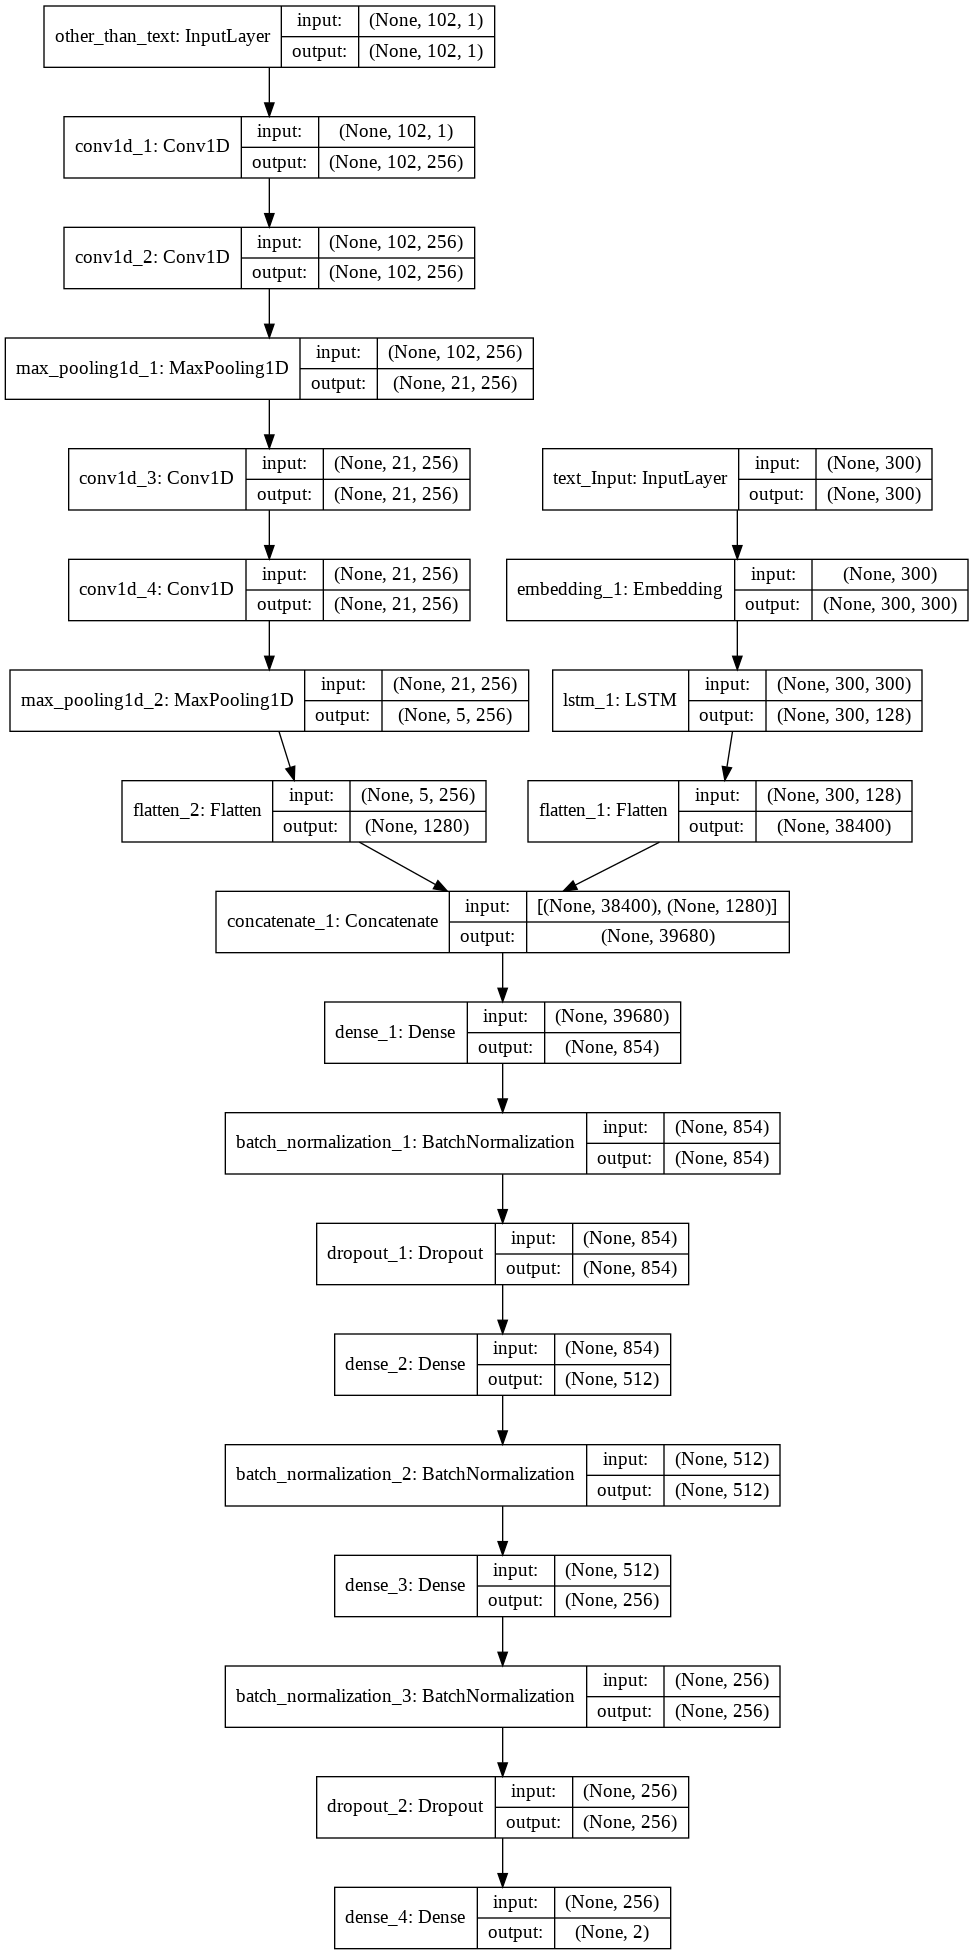

In [24]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
from keras.utils.vis_utils import plot_model
plot_model(model3, to_file='/content/drive/My Drive/LSTM_preprocessed/model3/model3_t2.png', show_shapes=True, show_layer_names=True)

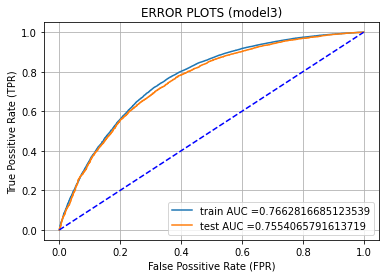

the maximum value of tpr*(1-fpr) 0.4963064277331075 for threshold 0.811


In [26]:

## Predict the test and train 
from sklearn.metrics import confusion_matrix
## Finding best threshold for predictions
def best_threshold(thresholds,fpr,tpr):
    t=thresholds[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


y_test_predict = model3.predict([padseq_x_test,other_than_text_test],use_multiprocessing=True)[:,1]
y_train_predict = model3.predict([padseq_x_train,other_than_text_train],use_multiprocessing=True)[:,1]

# if  os.path.isfile('model_predictions.pkl'):
#     os.remove('model_predictions.pkl')
#     print("File model_predictions Removed!")
#     with open('model_predictions.pkl','wb') as f:
#         pickle.dump([y_train_predict,y_test_predict],f)
 
## Store fpr and tpr rates 

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_predict)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_predict) 


#plot
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Possitive Rate (FPR)")
plt.ylabel("True Possitive Rate (TPR)")
plt.title("ERROR PLOTS (model3)")
plt.plot([0, 1], [0, 1],'b--')
plt.grid()
plt.show()

print("="*100)

best_t=best_threshold(tr_thresholds,train_fpr, train_tpr)


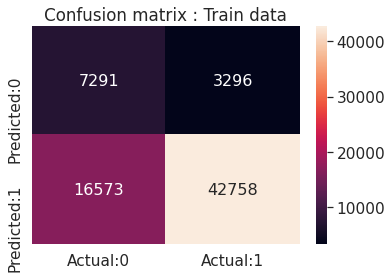

In [27]:
### PLOT the matrix for Train
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
# source : https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
df_cm = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_predict, best_t))
                     , range(2), range(2))
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='g',
            xticklabels=['Actual:0','Actual:1']
          ,yticklabels=['Predicted:0','Predicted:1']) # font size
plt.title('Confusion matrix : Train data')
plt.show()    

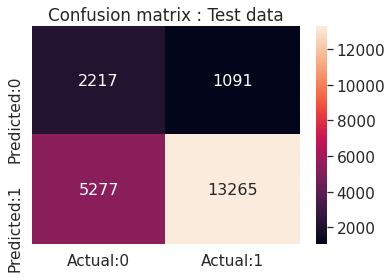

In [28]:
### PLOT the matrix for Test
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
# source : https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
df_cm = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_predict, best_t))
                     , range(2), range(2))
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='g',
            xticklabels=['Actual:0','Actual:1']
           ,yticklabels=['Predicted:0','Predicted:1']) # font size
plt.title('Confusion matrix : Test data')
plt.show()    

<li><b>Validation Loss,Validation aucroc,Train Loss,Train aucroc</b>
<img src='model3.jpg' width="800" height="800">



In [1]:
from prettytable import PrettyTable
pt=PrettyTable()
pt.field_names=["model","train_auc","test_auc"]
pt.add_row(["model_1","0.74","0.71"])
pt.add_row(["model_2","0.78","0.72"])
pt.add_row(["model_3","0.766","0.7554"])

print(pt)

+---------+-----------+----------+
|  model  | train_auc | test_auc |
+---------+-----------+----------+
| model_1 |    0.74   |   0.71   |
| model_2 |    0.78   |   0.72   |
| model_3 |   0.766   |  0.7554  |
+---------+-----------+----------+


##### Observations
        * Model3 performs best among all on test data with 0.76 auc with CNN and max pooling layers as features to our  
        dense layers.
        * As the number of units in dense layer increases the model tends to overfit hence we regularize using dropouts in
        between layers and l2 regularizer in all the dense layers.
        * using maxpool represents data in convoltional layer 1 and layer 2 in a abstracted way and avoids overfitting and
          reduces computational time while evaluation.
        * Using filtered words in Model2 in our dataset reduced train time and produced good results.
        * Model3 can be considered best fit among all as train and test AUC's are more close than Model1 and Model2 and also resulted with highest AUC.
        * using early stopping we are fitting data in epoch which produced best validation auc and stop the training when there is no improvement.